In [11]:
#Vu Hoang Phuc
#Ho Chi Minh City

Vì dữ liệu có dạng là chuối thời gian vì vậy tôi sẽ sử dụng mô hình LSTM

In [12]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

Tôi chỉ làm với một file dữ liệu là FPT.csv, những cổ phiếu của công ty khác thì tương tự
Ta chỉ cần đổi lại  tên file

In [13]:
#Đọc dữ liệu
df = pd.read_csv('FPT.CSV')
df.head()


,Ticker,Date/Time,Open,High,Low,Close,Volume,Open Interest
0,FPT,12/25/2018 9:15,30.89,30.89,30.89,30.89,35410,0
1,FPT,12/25/2018 9:16,30.81,30.81,30.81,30.81,190,0
2,FPT,12/25/2018 9:17,30.74,30.81,30.74,30.74,1120,0
3,FPT,12/25/2018 9:18,30.74,30.74,30.74,30.74,2120,0
4,FPT,12/25/2018 9:19,30.74,30.74,30.74,30.74,22500,0


Thêm cột biến động giá

In [14]:
df['PriceDiff'] = df['Close'].shift(-1) - df['Close']

In [15]:
# Loại bỏ hàng cuối cùng vì không có biến động giá
df = df[:-1]

In [16]:
# Chia dữ liệu thành train set và test set
train_size = int(len(df) * 0.8)
train_df = df[:train_size]
test_df = df[train_size:]

In [17]:
# Chuẩn hóa dữ liệu
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_train = scaler.fit_transform(train_df[['Close', 'Volume', 'PriceDiff']])
scaled_test = scaler.transform(test_df[['Close', 'Volume', 'PriceDiff']])

In [18]:
# Tạo dữ liệu cho mô hình LSTM
def create_lstm_dataset(dataset, look_back=1):
    data_X, data_y = [], []
    for i in range(len(dataset) - look_back):
        x = dataset[i:(i + look_back), :]
        y = dataset[i + look_back, 2]
        data_X.append(x)
        data_y.append(y)
    return np.array(data_X), np.array(data_y)

In [19]:
look_back = 60 # số lượng giá trước đó để dự đoán giá tiếp theo
train_X, train_y = create_lstm_dataset(scaled_train, look_back)
test_X, test_y = create_lstm_dataset(scaled_test, look_back)

In [20]:
# Xây dựng mô hình LSTM
model = Sequential()
model.add(LSTM(64, input_shape=(look_back, 3), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(32))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(train_X, train_y, epochs=100, batch_size=32)

Epoch 1/100
2434/2434 [==============================] - 61s 24ms/step - loss: 0.0030
Epoch 2/100
2434/2434 [==============================] - 60s 24ms/step - loss: 5.1432e-04
Epoch 3/100
2434/2434 [==============================] - 62s 26ms/step - loss: 2.9771e-04
Epoch 4/100
2434/2434 [==============================] - 61s 25ms/step - loss: 2.8954e-04
Epoch 5/100
2434/2434 [==============================] - 61s 25ms/step - loss: 2.8510e-04
Epoch 6/100
2434/2434 [==============================] - 62s 25ms/step - loss: 2.8331e-04
Epoch 7/100
2434/2434 [==============================] - 61s 25ms/step - loss: 2.8297e-04
Epoch 8/100
2434/2434 [==============================] - 61s 25ms/step - loss: 2.8293e-04
Epoch 9/100
2434/2434 [==============================] - 59s 24ms/step - loss: 2.8285e-04
Epoch 10/100
2434/2434 [==============================] - 59s 24ms/step - loss: 2.8310e-04
Epoch 11/100
2434/2434 [==============================] - 59s 24ms/step - loss: 2.8264e-04
Epoch 12/100

In [21]:
# Đánh giá mô hình
train_score = model.evaluate(train_X, train_y, verbose=0)
test_score = model.evaluate(test_X, test_y, verbose=0)
print('Train loss:', train_score)
print('Test loss:', test_score)

Train loss: 0.0002755268942564726
Test loss: 0.00035111058969050646


In [22]:
# Dự đoán biến động giá cổ phiếu trên tập test
predicted_price_diff = model.predict(test_X)
print(predicted_price_diff)

607/607 [==============================] - 8s 12ms/step
[[0.65211546]
 [0.6549951 ]
 [0.64444727]
 ...
 [0.6484104 ]
 [0.6484119 ]
 [0.6563431 ]]


In [29]:
# # Chuyển đổi biến động giá cổ phiếu về đơn vị đồng
# predicted_price_diff = scaler.inverse_transform(predicted_price_diff.reshape(-1, 1))
# test_y = scaler.inverse_transform(test_y.reshape(-1, 1))
# print(predicted_price_diff)

In [25]:
# Tính giá tiếp theo dựa trên giá hiện tại và biến động giá dự đoán được
predicted_price = test_df['Close'].values[:-look_back] + predicted_price_diff.ravel()
actual_price = test_df['Close'].values[:-look_back] + test_y.ravel()

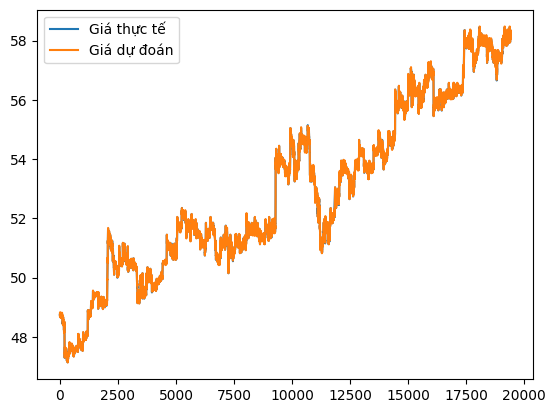

In [28]:
#Vẽ đồ thị so sánh giá thực tế và giá dự đoán được
import matplotlib.pyplot as plt
plt.plot(predicted_price, label='Giá thực tế')
plt.plot(actual_price, label='Giá dự đoán')
plt.legend()
plt.show()

Đồ thị của biến động giá

In [ ]:
plt.plot(predicted_price_diff, label='Biến động giá')